In [1]:

import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from visu_utils import *
import re

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
SUBSET_NAME = "comprehensive"

In [25]:


df_base = pd.read_csv('output/comprehensive_2/base.csv')
df_mis = pd.read_csv('output/comprehensive_2/mis.csv')
df_rouge = pd.read_csv('output/comprehensive_2/rouge.csv')

df_classifiers = pd.read_csv('output/comprehensive_3/classifiers.csv')
model_sizes = pd.read_csv('output/model_sizes.csv')

df_bert = pd.read_csv('output/comprehensive_4/bertrecall.csv')
df_blanc = pd.read_csv('output/comprehensive_4/blanc.csv')
df_blanc = pd.read_csv('output/comprehensive_4/blanc.csv')
df_bart = pd.read_csv('output/comprehensive_2/bart.csv')
df_emb = pd.read_csv('output/comprehensive_2/emb.csv')

df_smart = pd.read_csv('output/comprehensive_4/comprehensive_merged/smart.csv')

df_base['source'] = df_base["Unnamed: 0"]
df_rouge['source'] = df_rouge["Unnamed: 0"]
df_classifiers['source'] = df_classifiers["Unnamed: 0"]
df_mis['source'] = df_mis["filename"]
df_bert['source'] = df_bert["Unnamed: 0"]
df_emb['source'] = df_emb["Unnamed: 0"]
df_bart['source'] = df_bart["Unnamed: 0"]
df_blanc['source'] = df_blanc["Unnamed: 0"]
df_smart['source'] = df_smart["Unnamed: 0"]


# drop I(text -> summary) and I(summary -> text), H(text) and H(summary) and H(text|summary), H(summary|text) from df_base
df_base = df_base.drop(
    columns=['I(text -> summary)', 'I(summary -> text)', 'H(text)', 'H(summary)', 'H(text|summary)', 'H(summary|text)',
             'metadata/Embedding model'])

# merge all dataframes on source
df_comprehensive = df_base.merge(df_rouge, on='source', how="outer")
df_comprehensive = df_comprehensive.merge(df_classifiers, on='source')
# merge emb and bert
df_comprehensive = df_comprehensive.merge(df_bert, on='source')
df_comprehensive = df_comprehensive.merge(df_bart, on='source')
df_comprehensive = df_comprehensive.merge(df_emb, on='source')
df_comprehensive = df_comprehensive.merge(df_blanc, on='source')
df_comprehensive = df_comprehensive.merge(df_smart, on='source')

df_comprehensive = df_comprehensive.merge(df_mis[['source', 'I(summary -> text)', 'I(text -> summary)', 'H(text)',
                                                  'H(summary)', 'H(text|summary)', 'H(summary|text)',
                                                  'metadata/Embedding model']], on='source')


df_comprehensive['metadata/Model name'] = df_comprehensive['source'].apply(lambda x: x.split('-_-')[0])
df_comprehensive['metadata/Decoding config'] = df_comprehensive['source'].apply(lambda x: x.split('-_-')[2])
df_comprehensive['metadata/Dataset name'] = df_comprehensive['source'].apply(lambda x: x.split('-_-')[1])


# remove all columns with gold
df_comprehensive = df_comprehensive[[c for c in df_comprehensive.columns if "gold" not in c]]


df_comprehensive = df_comprehensive.merge(model_sizes, on='metadata/Model name')

# replace first _ in model by /
df_comprehensive['metadata/Model name'] = df_comprehensive['metadata/Model name'].apply(
    lambda x: x.replace('_', '/', 1))


# get all pair of columns with _x, _y
def get_pair_columns(df):
    cols = df.columns
    pairs = []
    for c in cols:
        if c.endswith("_x"):
            pairs.append((c, c.replace("_x", "_y")))
    return pairs

# add column without suffix _x or _y, getting the non nan value or the _x value if both are not nan
def add_column(df, col1, col2):
    df[col1.replace("_x", "")] = df.apply(lambda x: x[col1] if pd.isna(x[col2]) else x[col2], axis=1)

    return df

# remove all unamed columns
df_comprehensive = df_comprehensive[[c for c in df_comprehensive.columns if "Unnamed" not in c]]

# add columns
for col1, col2 in get_pair_columns(df_comprehensive):
    df_comprehensive = add_column(df_comprehensive, col1, col2)
    
# drop columns with _x or _y
df_comprehensive = df_comprehensive[[c for c in df_comprehensive.columns if not c.endswith("_x") and not c.endswith("_y")]]


EMBEDDER_NAME = df_comprehensive['metadata/Embedding model'].unique()[0].replace('/', '_')






/tmp/ipykernel_40495/3383173564.py:36: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_comprehensive = df_comprehensive.merge(df_bert, on='source')
/tmp/ipykernel_40495/3383173564.py:38: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_comprehensive = df_comprehensive.merge(df_emb, on='source')
/tmp/ipykernel_40495/3383173564.py:40: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_comprehensive = df_comprehensive.merge(df_smart, on='source')


In [26]:
df_no_arxiv = df_comprehensive[~df_comprehensive['metadata/Model name'].str.contains('arxiv')]

In [27]:
df_comprehensive.columns

Index(['metadata/Decoding config', 'metadata/Date', 'metadata/Model name',
       'metadata/Dataset name', 'source', 'common/rouge1', 'common/rouge2',
       'common/rougeL', 'common/rougeLsum',
       'wesleyacheng_news-topic-classification-with-bert/l2',
       'wesleyacheng_news-topic-classification-with-bert/l1',
       'wesleyacheng_news-topic-classification-with-bert/dot',
       'wesleyacheng_news-topic-classification-with-bert/kl',
       'wesleyacheng_news-topic-classification-with-bert/proba_of_error',
       'SamLowe_roberta-base-go_emotions/dot',
       'SamLowe_roberta-base-go_emotions/kl',
       'SamLowe_roberta-base-go_emotions/l1',
       'SamLowe_roberta-base-go_emotions/l2',
       'SamLowe_roberta-base-go_emotions/proba_of_error',
       'mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis/dot',
       'mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis/kl',
       'mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis/l1',
 

In [28]:
# print all model names:


# ['google/pegasus-arxiv' 'sshleifer/distill-pegasus-cnn-16-4'
#  'sshleifer/distilbart-cnn-12-6' 'Falconsai/medical_summarization'
#  'airKlizz/mt5-base-wikinewssum-all-languages'
#  'sshleifer/distilbart-xsum-12-1' 'google/pegasus-large'
#  'facebook/bart-large-cnn' 'sshleifer/distilbart-cnn-6-6'
#  'sshleifer/distilbart-cnn-12-3' 'sshleifer/distill-pegasus-xsum-16-4'
#  'google/pegasus-multi_news' 'sshleifer/distilbart-xsum-6-6'
#  'Falconsai/text_summarization']

# Make a column that records if XSUM/CNN Daily Mail are IN or OOD

is_ood_map = {'google/pegasus-arxiv': 'OOD', 'sshleifer/distill-pegasus-cnn-16-4': 'IN',
              'sshleifer/distilbart-cnn-12-6': 'IN', 'Falconsai/medical_summarization': 'OOD',
              'airKlizz/mt5-base-wikinewssum-all-languages': 'IN', 'sshleifer/distilbart-xsum-12-1': 'IN',
              'google/pegasus-large': 'IN', 'facebook/bart-large-cnn': 'IN',
              'sshleifer/distilbart-cnn-12-3': 'IN',
              'sshleifer/distill-pegasus-xsum-16-4': 'IN', 'google/pegasus-multi_news': 'IN',
              'sshleifer/distilbart-xsum-6-6': 'IN', 'Falconsai/text_summarization': 'IN',
              'sshleifer/distilbart-cnn-12-1': 'IN', 'sshleifer/distilbart-cnn-6-3': 'IN',
              'sshleifer/distilbart-cnn-6-1': 'IN', 'sshleifer/distilbart-cnn-12-12': 'IN',
              'sshleifer/distilbart-cnn-12-9': 'IN', 'sshleifer/distilbart-cnn-12-1': 'IN',
              'sshleifer/distilbart-cnn-6-6': 'IN', 'sshleifer/distilbart-cnn-12-3': 'IN',
              "mistralai/Mistral-7B-Instruct-v0.2" : "IN",
              }

df_comprehensive['metadata/IND/OOD'] = df_comprehensive['metadata/Model name'].apply(lambda x: is_ood_map[x])



### Model summary table

In [29]:



table = make_table_model_summary(df_comprehensive)

style = table.style

style = style.format(precision=2)
style = style.format_index(escape="latex", axis=0)

# add background gradient

# convert to latex
path = f"../../../papers/Mutual-information-for-summarization/tables/{SUBSET_NAME}_{EMBEDDER_NAME}_model_summaries_table.tex"
# create parent
Path(path).parent.mkdir(parents=True, exist_ok=True)

latex_code = style.to_latex(clines="skip-last;data", sparse_index=True, sparse_columns=True,
                            caption="Summary of the models we benchmarked with their name on the Huggingface hub, size and performance metrics.",
                            label="tab:model_summaries", environment="table*", hrules=True, convert_css=True)

import re

# add a resize box around the tabular
latex_code = re.sub(r"\\begin{tabular}", r"\\resizebox{\\textwidth}{!}{\\begin{tabular}", latex_code)
latex_code = re.sub(r"\\end{tabular}", r"\\end{tabular}}", latex_code)

# add centering to the table environment
latex_code = re.sub(r"\\begin{table\*}", r"\\begin{table*}[h!]\\centering", latex_code)

# save latex code
with open(path, 'w') as f:
    f.write(latex_code)
    
display(style)

# table = table[['$I(T,S)$', '\\texttt{ROUGE-L}', '\\texttt{BERTScore}', '\\texttt{BARTScore}', 'M. I.', 'Attr.', 'Conc.']]
# table = table.rename(columns={'\\texttt{ROUGE-L}': 'ROUGE-L', '\\texttt{BERTScore}': 'BERTScore', '\\texttt{BARTScore}': 'BARTScore', 'M. I.': 'Main ideas', 'Attr.': 'Attribution', 'Conc.': 'Conciseness'})
# 
# table = table.groupby(level=0, axis=0).mean().melt(var_name='metric', value_name='value', ignore_index=False)
# table["ones"] = 1
# table = table.reset_index()
# 
# # make ranking of Model by metric
# 
# # Rank model by metric
# table['rank'] = 1 + table.sort_values(['metric', 'value'], ascending=False).groupby('metric').cumcount()
# table
# 
# fig, ax = plt.subplots(1, 1, figsize=(40, 35))
# marker = ['o', 's', 'D', 'v', '^', '<', '>', 'p', 'h', 'H', 'd', 'P', 'X', '*', '8', '1', '2', '3', '4', 'x', '|', '_', '']
# line_params = {'linewidth': 10, 'alpha': 0.5, 'markersize': 20}
# sns.pointplot(data=table.reset_index(), x='metric', y='rank', hue='Model', ax=ax, linewidth=30, palette='tab20', alpha=0.8, markers=marker, markersize=20)
# 
# ax.set_xlabel("Metric", fontsize=50, fontweight='bold')
# ax.set_ylabel("Rank", fontsize=50, fontweight='bold')
# 
# ax.tick_params(axis='x', labelsize=50, rotation=30, labelfontfamily='monospace')
# ax.tick_params(axis='y', labelsize=50)
# 
# # legend fontsize
# # legend outside below
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=2, fontsize=50)
# 
# # add grid
# ax.grid(True, which='both', axis='both', linestyle='solid')
# 
# path = f"../../../papers/Mutual-information-for-summarization/img/{SUBSET_NAME}_{EMBEDDER_NAME}_model_summaries_ranking.png"
# # create parent
# Path(path).parent.mkdir(parents=True, exist_ok=True)
# 
# fig.tight_layout()
# plt.savefig(path, dpi=300, bbox_inches='tight')







/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/summarization/summarization_evaluation/visu_utils.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = df.groupby(["metadata/Model name", "metadata/Dataset name"]).mean()


In [30]:
sns.set_style("whitegrid")

In [35]:


df_no_arxiv['H'] = df_no_arxiv[['H(text|summary)', 'H(summary|text)']].mean(axis=1)
table = make_correlation_table(df_no_arxiv).transpose()

# take average over the first level of columns

table = table.groupby(level=1, axis=1).mean()


display(table)

print(table.loc[:, ['$I(S;T)$', 'BLANC', 'SMARTL','\\texttt{BERTScore}', 'BERTScore Precision', 'BERTScore Recall']].round(2).to_markdown())


# table.columns = pd.MultiIndex.from_tuples([(c[0].replace('_', '-'), c[1]) for c in table.columns])

style = table.style

style = style.format(precision=2)
# style = style.format_index(escape="latex", axis=0)

# highlight max for each dataset with bfseries
# list_datasets = set(table.columns.get_level_values(0))
#list_metrics = set(table.columns.get_level_values(1))
idx = pd.IndexSlice
# for dataset in list_datasets:
#    style = style.highlight_max(axis=1, subset=(idx[:], idx[dataset, :]), props='bfseries:')

# add background gradient
style = style.background_gradient(cmap='viridis', vmin=0.2, vmax=1)

# convert to latex
path = f"../../../papers/Mutual-information-for-summarization/tables/{SUBSET_NAME}_{EMBEDDER_NAME}_correlation_table_full.tex"
# create parent
Path(path).parent.mkdir(parents=True, exist_ok=True)

latex_code = style.to_latex(clines="skip-last;data", sparse_index=True, sparse_columns=True,
                            caption="Correlation between MI and ROUGE, and Seahorse metrics and probability of success of the classifcation task, grouped by datasets for non-trivial decoding strategies. SH. stands for Seahorse metrics and CT. for classification tasks.",
                            label="tab:correlation_table", environment="table", hrules=True, convert_css=True, multicol_align="c")

import re

# add a resize box around the tabular
latex_code = re.sub(r"\\begin{tabular}", r"\\resizebox{0.5\\textwidth}{!}{\\begin{tabular}", latex_code)
latex_code = re.sub(r"\\end{tabular}", r"\\end{tabular}}", latex_code)

# add centering to the table environment
latex_code = re.sub(r"\\begin{table}", r"\\begin{table}\\centering", latex_code)

# save latex code
with open(path, 'w') as f:
    f.write(latex_code)
    

# print(latex_code)


/tmp/ipykernel_40495/3590862542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_arxiv['H'] = df_no_arxiv[['H(text|summary)', 'H(summary|text)']].mean(axis=1)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/summarization/summarization_evaluation/visu_utils.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  splits = x.split("/")
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/summarization/summarization_evaluation/visu_utils.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  splits = x.split("/")
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/su

Metric                         $I(S;T)$  Attribution  BERTScore Precision  \
SH.    Attribution             0.551551     1.000000             0.803761   
       Comprehensible          0.072039     0.063541             0.120195   
       Conciseness             0.631697     0.556386             0.614896   
       Grammar                -0.241954    -0.165763            -0.119170   
       Main ideas              0.516239     0.290208             0.346862   
       Repetition              0.032332    -0.053431            -0.005372   
CT.    Sentiment analysis      0.627246     0.485520             0.530718   
       GPT detector            0.592946     0.709772             0.678426   
       Policy classification   0.584211     0.373145             0.466210   
       Emotion classification  0.560256     0.486959             0.457848   
Emb.   Emb. Paraphrase         0.810452     0.624664             0.704860   
Common \texttt{ROUGE-L}        0.401856     0.409280             0.375678   
       \texttt{BERTScore}      0.699878     0.690501             0.793455   
       BERTScore Precision     0.679121     0.803761             1.000000   
       BERTScore Recall        0.523712     0.513651             0.531136   
       \texttt{BARTScore}      0.603956     0.877070             0.875214   
       BLANC                   0.459927     0.478584             0.475556   
       SMART1                  0.397216     0.484835             0.430720   
       SMART2                  0.397216     0.484835             0.430720   
       SMARTL                  0.397216     0.484835             0.430720   

Metric                         BERTScore Recall     BLANC  Main ideas  \
SH.    Attribution                     0.513651  0.478584    0.290208   
       Comprehensible                  0.027888  0.063346    0.353211   
       Conciseness                     0.532357  0.487228    0.706960   
       Grammar                        -0.185788 -0.154432    0.098510   
       Main ideas                      0.476972  0.454212    1.000000   
       Repetition                     -0.053333 -0.147692    0.188083   
CT.    Sentiment analysis              0.590780  0.586412    0.329466   
       GPT detector                    0.663525  0.590920    0.365510   
       Policy classification           0.739375  0.657260    0.603684   
       Emotion classification          0.544350  0.597897    0.376431   
Emb.   Emb. Paraphrase                 0.421099  0.377827    0.469597   
Common \texttt{ROUGE-L}                0.752039  0.718437    0.274139   
       \texttt{BERTScore}              0.737680  0.663443    0.450842   
       BERTScore Precision             0.531136  0.475556    0.346862   
       BERTScore Recall                1.000000  0.793309    0.476972   
       \texttt{BARTScore}              0.534701  0.499634    0.323565   
       BLANC                           0.793309  1.000000    0.454212   
       SMART1                          0.691429  0.684298    0.213529   
       SMART2                          0.691429  0.684298    0.213529   
       SMARTL                          0.691429  0.684298    0.213529   

Metric                           SMART1    SMART2    SMARTL  \
SH.    Attribution             0.484835  0.484835  0.484835   
       Comprehensible         -0.186325 -0.186325 -0.186325   
       Conciseness             0.305836  0.305836  0.305836   
       Grammar                -0.391795 -0.391795 -0.391795   
       Main ideas              0.213529  0.213529  0.213529   
       Repetition             -0.280928 -0.280928 -0.280928   
CT.    Sentiment analysis      0.548436  0.548436  0.548436   
       GPT detector            0.631212  0.631212  0.631212   
       Policy classification   0.473746  0.473746  0.473746   
       Emotion classification  0.468961  0.468961  0.468961   
Emb.   Emb. Paraphrase         0.282295  0.282295  0.282295   
Common \texttt{ROUGE-L}        0.903932  0.903932  0.903932   
       \texttt{BERTScore}    

|                                   |   $I(S;T)$ |   BLANC |   SMARTL |   \texttt{BERTScore} |   BERTScore Precision |   BERTScore Recall |
|:----------------------------------|-----------:|--------:|---------:|---------------------:|----------------------:|-------------------:|
| ('SH.', 'Attribution')            |       0.55 |    0.48 |     0.48 |                 0.69 |                  0.8  |               0.51 |
| ('SH.', 'Comprehensible')         |       0.07 |    0.06 |    -0.19 |                 0.09 |                  0.12 |               0.03 |
| ('SH.', 'Conciseness')            |       0.63 |    0.49 |     0.31 |                 0.59 |                  0.61 |               0.53 |
| ('SH.', 'Grammar')                |      -0.24 |   -0.15 |    -0.39 |                -0.18 |                 -0.12 |              -0.19 |
| ('SH.', 'Main ideas')             |       0.52 |    0.45 |     0.21 |                 0.45 |                  0.35 |               0.48 |
| ('SH.', 'Repetitio

/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/summarization/summarization_evaluation/visu_utils.py:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(df_dataset)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/summarization/summarization_evaluation/visu_utils.py:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(df_dataset)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/summarization/summarization_evaluation/visu_utils.py:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(df_dataset)


,Attribution,Comprehensible,Conciseness,Grammar,Main ideas,Repetition
Metric,,,,,,
$I(S;T)$,0.55,0.07,0.63,-0.24,0.52,0.03
BERTScore Precision,0.80,0.12,0.61,-0.12,0.35,-0.01
BERTScore Recall,0.51,0.03,0.53,-0.19,0.48,-0.05
BLANC,0.48,0.06,0.49,-0.15,0.45,-0.15
\texttt{BARTScore},0.88,0.12,0.59,-0.11,0.32,-0.07
\texttt{BERTScore},0.69,0.09,0.59,-0.18,0.45,0.01
\texttt{ROUGE-L},0.41,-0.15,0.34,-0.38,0.27,-0.26


Index(['Metric', 'Attribution', 'Comprehensible', 'Conciseness', 'Grammar',
       'Main ideas', 'Repetition'],
      dtype='object')


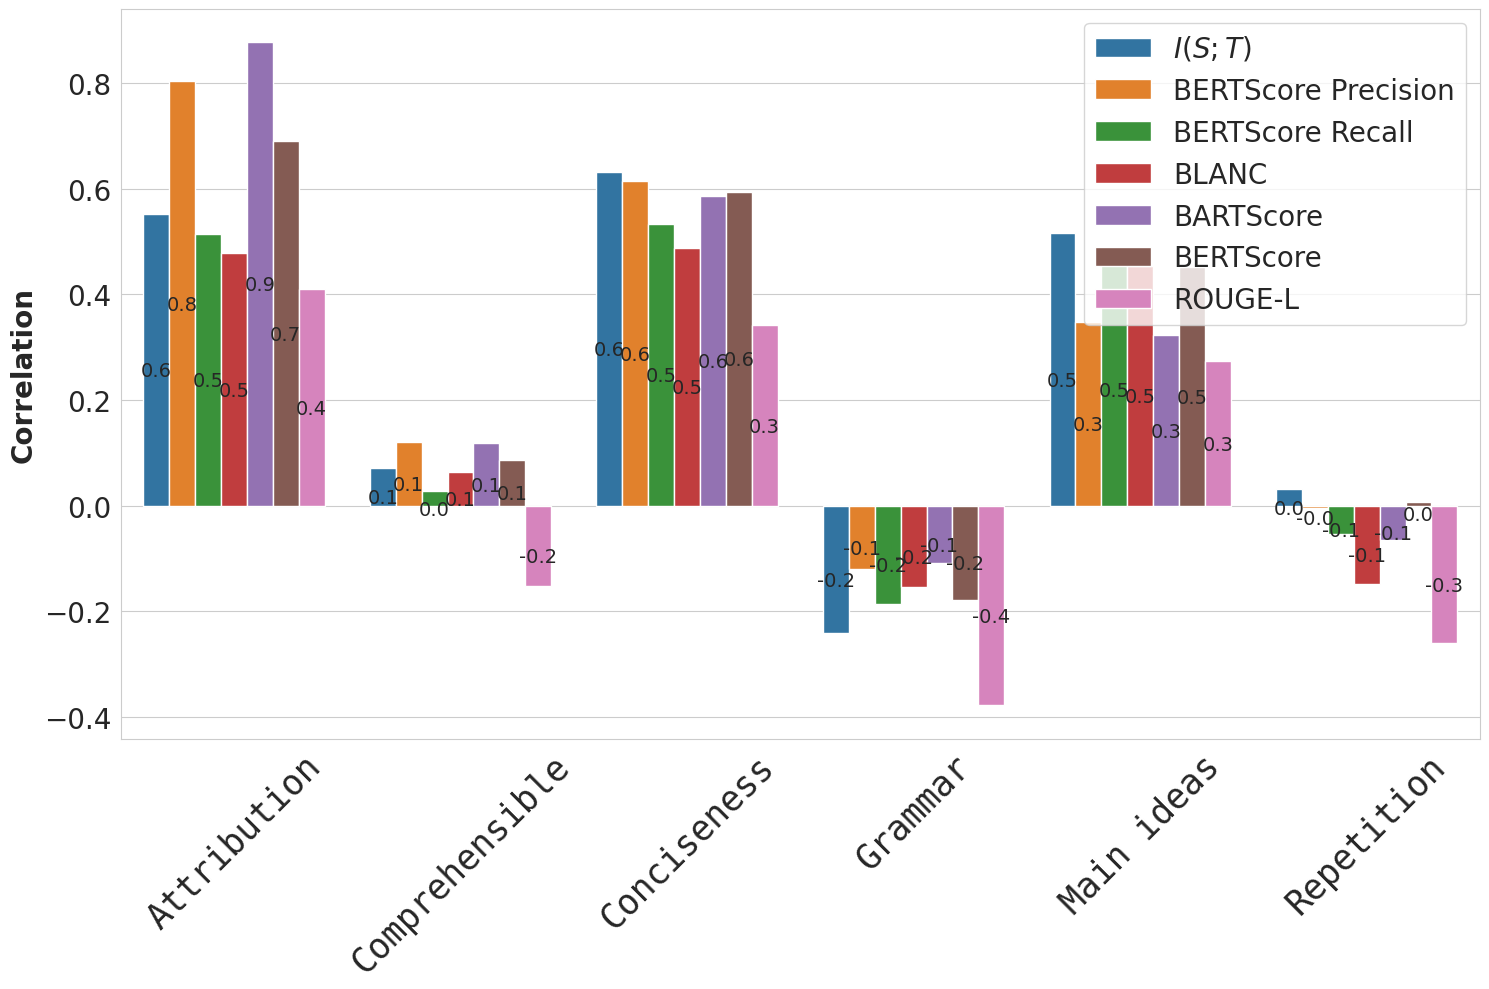

In [32]:

table = make_correlation_table(df_no_arxiv)

table = table.groupby(level=1, axis=0).mean()
table_sh = table['SH.']

# drop Main ideas and Attribution rows
table_sh = table_sh.drop(index=['Main ideas', 'Attribution'])

style = table_sh.style

style = style.format(precision=2)

# export to latex
path = f"../../../papers/Mutual-information-for-summarization/tables/{SUBSET_NAME}_{EMBEDDER_NAME}_correlation_table_sh.tex"

# create parent
Path(path).parent.mkdir(parents=True, exist_ok=True)

latex_code = style.to_latex(clines="skip-last;data", sparse_index=True, sparse_columns=True,
                            caption="Common quality estimation metrics correlation with human judgement estimated by Seahorse metrics.",
                            label="tab:correlation_table_sh", environment="table", hrules=True, convert_css=True, multicol_align="c")

latex_code = re.sub(r"\\begin{tabular}", r"\\resizebox{0.5\\textwidth}{!}{\\begin{tabular}", latex_code)
latex_code = re.sub(r"\\end{tabular}", r"\\end{tabular}}", latex_code)

# add centering to the table environment
latex_code = re.sub(r"\\begin{table}", r"\\begin{table}\\centering", latex_code)

shorten_map = {"Conciseness": "Conc.", "Main ideas": "M. Ideas", "Attribution": "Attr.", "Grammar": "Gram.", "Comprehensible": "Compr.", "Concise": "Cons."}

for k, v in shorten_map.items():
    latex_code = latex_code.replace(k, v)

with open(path, 'w') as f:
    f.write(latex_code)
    
display(style)

# remove latex commands from metric names
def remove_latex(x):
    # get everything between { and }
    matches = re.findall(r"\{(.*)\}", x)
    if len(matches) > 0:
        return matches[0]
    else:
        return x

table_sh = table_sh.rename(index=remove_latex)

# melt table
table_sh = table_sh.reset_index()
print(table_sh.columns)
table_sh = table_sh.melt(var_name='metric', value_name='correlation', id_vars=['Metric'])

# barplot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# barplot with annotations
sns.barplot(data=table_sh, x='metric', y='correlation', hue='Metric', ax=ax, palette='tab10')

for container in ax.containers:
    ax.bar_label(container, fmt='\n%.1f', label_type='center', fontsize=14)

ax.set_xlabel("")
ax.set_ylabel("Correlation", fontsize=20, fontweight='bold')

ax.tick_params(axis='x', labelsize=25, rotation=45, labelfontfamily='monospace')
ax.tick_params(axis='y', labelsize=20)

# legend fontsize
ax.legend(fontsize=20)

path = f"../../../papers/Mutual-information-for-summarization/img/{SUBSET_NAME}_correlation_table_sh.png"
# create parent
Path(path).parent.mkdir(parents=True, exist_ok=True)

fig.tight_layout()
plt.savefig(path, dpi=300, bbox_inches='tight')




In [ ]:

table = make_correlation_table(df_no_arxiv)

table = table.groupby(level=1, axis=0).mean()

table_sh = pd.concat([table['CT.'], table['Emb.']], axis=1)

# columns short names
shorten_map = {"Sentiment analysis": "Sent. analysis", "GPT detector": "GPT det.", "Topic classification": "Topic.", "Policy classification": "Policy", "Emotion classification": "Emotion", "Emb. Paraphrase": "Emb."}

table_sh = table_sh.rename(columns=shorten_map)

style = table_sh.style

style = style.format(precision=2)

path = f"../../../papers/Mutual-information-for-summarization/tables/{SUBSET_NAME}_{EMBEDDER_NAME}_correlation_table_ct.tex"

# create parent
Path(path).parent.mkdir(parents=True, exist_ok=True)

latex_code = style.to_latex(clines="skip-last;data", sparse_index=True, sparse_columns=True,
                            caption="Common quality estimation metrics correlation with the performance on the downstream classification tasks. Where Sent. analysis stands for sentiment analysis, GPT det. for GPT detector, Topic. for topic classification, Policy for policy classification, Emotion for emotion classification and Emb. for paraphrase embedding.",
                            label="tab:correlation_table_ct", environment="table", hrules=True, convert_css=True, multicol_align="c")

latex_code = re.sub(r"\\begin{tabular}", r"\\resizebox{0.5\\textwidth}{!}{\\begin{tabular}", latex_code)
latex_code = re.sub(r"\\end{tabular}", r"\\end{tabular}}", latex_code)

# add centering to the table environment
latex_code = re.sub(r"\\begin{table}", r"\\begin{table}\\centering", latex_code)


    
with open(path, 'w') as f:
    f.write(latex_code)
    
display(style)



In [ ]:

import math


# radar chart function

def make_radar_chart(df, indexes, columns, ax, ylim, yticks, legend):
    df = df.copy()

    # retrieve data
    data = df.loc[indexes, columns]
    
    # data = data.sort_index(axis=1)
    
    # make a plot for each row


    # to 0 if negative
    # values = np.array([0.01 if v < 0 else v for v in values])
    # get columns
    b_angles = [n / float(len(columns)) * 2 * math.pi for n in range(len(columns))]
    
    angles = b_angles + b_angles[:1]
    b_angles = b_angles + b_angles[:1]

    # dic with angle for each column
    angles_dict = {c: a for c, a in zip(columns, b_angles)}


    color_list = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan']
    
    category_color_list = ['cornflowerblue', 'indianred', 'lightgreen', 'lightcoral', 'lightpink', 'lightgrey', 'lightyellow', 'lightcyan', 'lightseagreen']
    category_hat_list = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.']
    
    last_angle = 0
    for k, level_0 in enumerate(data.columns.get_level_values(0).unique()):
        print(level_0)
        print(data[level_0].columns)
        
        start_angle =  angles_dict[(level_0, data[level_0].columns[0])] 
        end_angle = angles_dict[(level_0, data[level_0].columns[-1])]

        if start_angle > end_angle:
            start_angle, end_angle = end_angle, start_angle

        start_angle = start_angle - 1/(float(len(columns))) * math.pi
        
        # if k == len(data.columns.get_level_values(0).unique()) - 1:
        #     end_angle = 2 * math.pi - 1/(float(len(columns))) * math.pi
        # else:
        end_angle = end_angle + 1/(float(len(columns))) * math.pi
            
        langles = np.arange(start_angle, end_angle, 0.01)

        ax.fill_between(langles,  0.9*np.ones(len(langles)), 1.2*np.ones(len(langles)), alpha=0.6, color=category_color_list[k], label=level_0, hatch=category_hat_list[k])

    
    for k, (idx, row) in enumerate(data.iterrows()):
        # get values
        values = row.values
        values = np.concatenate((values, [values[0]]))
        
        # plot
        if "ROUGE" in idx:
            idx = "ROUGE-L"
        elif "BERT" in idx:
            idx = "BERTScore"
        elif "BART" in idx:
            idx = "BARTScore"

        linestyles = ['dotted', 'dashed', 'dashdot', 'looosely dashed', 'densely dashed', 'loosely dotted', 'densely dotted', 'loosely dashdotted', 'densely dashdotted', 'loosely dashdotdotted', 'densely dashdotdotted']
        # fill
        if "I(S;T)" in idx:
            ax.plot(angles, values, linewidth=5, linestyle='solid', label=idx, color=color_list[k])
            ax.fill(angles, values, alpha=0.1, color=color_list[k])
        else:
            ax.plot(angles, values, linewidth=3, linestyle='--', label=idx, color=color_list[k])
            ax.fill(angles, values, alpha=0.1, color=color_list[k])

        # add legend

        # add grid
    ax.grid(True, which='both', axis='both', linestyle='solid')
    

    # set xticks
    ax.set_xticks(angles[:-1])

    # set xtick labels
    cc = []
    for c in columns:
        if "ROUGE" in c[1]:
            cc.append("ROUGE-L")
        elif "BERT" in c[1]:
            cc.append("BERTScore")
        elif "BART" in c[1]:
            cc.append("BARTScore")

        else:
            cc.append(c[1])
    ax.set_xticklabels(cc, fontsize=20, fontweight='bold')
    

    # set yticks
    ax.set_yticks(yticks)

    # set ytick labels
    ax.set_yticklabels(yticks, fontsize=16)

    # set ylim
    ax.set_ylim(ylim)
        
        
# draw a circle at y=0
    ax.plot(np.linspace(0, 2 * math.pi, 100), np.zeros(100), linestyle='--', color='black', linewidth=2, label="Correlation = 0")
    
    ax.set_axisbelow(False)

table = make_correlation_table(df_no_arxiv).transpose()

datasets = ['xsum', 'cnn_dailymail', 'multi_news']

dddf = table['xsum'].transpose()

columns = [c for c in dddf.columns]

fig, ax = plt.subplots(1, len(datasets), figsize=(30, 25), subplot_kw=dict(projection='polar'))



for k, d in enumerate(datasets):
    dddf = table[d].transpose()
    make_radar_chart(df=dddf, indexes=dddf.index, columns=columns, ax=ax[k], ylim=(-0.6, 1.1), yticks=[-0.6, -0.2, 0.2, 0.6, 1.0], legend=False)
    
    if d == "cnn_dailymail":
        # ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=20)
        handles, labels = ax[k].get_legend_handles_labels()
    else:
        ax[k].legend().remove()
    
    ax[k].set_title(d, fontsize=22, fontweight='bold')
    
# make global legend
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=3, fontsize=20)

fig.tight_layout()
fig.savefig(f"../../../papers/Mutual-information-for-summarization/img/{SUBSET_NAME}_{EMBEDDER_NAME}_radar_chart_all.png", dpi=300, bbox_inches='tight')



# columns = [c for c in dddf.columns if "SH." in c]
# 
# fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection='polar'))
# make_radar_chart(df=dddf, indexes=dddf.index, columns=columns, ax=ax, ylim=(-1, 1), yticks=[-1, -0.6, -0.2, 0.2, 0.6, 1.0])
# 
# 
# columns = [c for c in dddf.columns if "CT." in c]
# fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection='polar'))
# make_radar_chart(df=dddf, indexes=dddf.index, columns=columns, ax=ax, ylim=(0, 1), yticks=[0.2, 0.6, 0.8, 1.0]) 

In [ ]:

sns.set_theme(style="whitegrid")

ROUGES = ["common/rougeLsum"]
MI = ['I(summary -> text)', 'I(text -> summary)', 'max mi', 'min mi']
SHM = [c for c in df_comprehensive.columns if "SHMetric" in c and "proba_1" in c]
# keep only Attribution, Main idea, Conciseness
SHM = [c for c in SHM if "Attribution" in c or "Main ideas" in c or "Conciseness" in c]

map_tasks = {"mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis": "Sentiment analysis",
             "roberta-base-openai-detector": "GPT detector",
             "manifesto-project_manifestoberta-xlm-roberta-56policy-topics-context-2023-1-1" : "Topic classification",
             }

classification_tasks_error = [c + "/proba_of_error" for c in map_tasks.keys()]
classification_tasks = [c + "/proba_of_success" for c in map_tasks.keys()]

# make proba_of_error proba_of_success
df_comprehensive[classification_tasks] = 1 - df_comprehensive[classification_tasks_error]


def plot_multiple_datasets_correlations(df, COLS, metric, name):
    sns.set_theme(style="whitegrid")
    df = df.copy()

    df = df[~df['metadata/Decoding config'].str.contains("short")]

    df = df[~df['metadata/Decoding config'].isin([f"beam_sampling_{k}" for k in [5, 10, 20, 50]])]

    datasets = set(df['metadata/Dataset name'].dropna().unique())
    datasets -= set(['peer_read', 'arxiv', 'rotten_tomatoes'])

    fig, axes = plt.subplots(len(datasets), len(COLS), figsize=(10, 10), sharey=False, sharex=False, dpi=300)

    def rename_cols(x):
        if "SHMetric" in x:
            return x.split('/')[1]
        else:
            return map_tasks[x.split('/')[0]]

    for idx, col in enumerate(COLS):
        for didx, ds in enumerate(datasets):
            group = df[df['metadata/Dataset name'] == ds]
            sns.set_theme(style="whitegrid")

            sns.regplot(data=group, x=metric, y=col, ax=axes[didx, idx], x_ci=None, ci=False, scatter=False,
                        line_kws={'alpha': 0.5, 'linewidth': 5})
            sns.scatterplot(data=group, x=metric, y=col, hue='metadata/Model name', style='metadata/Model name',
                            ax=axes[didx, idx], palette='tab20', s=300)

            axes[didx, idx].set_xlabel("")
            if didx == 0:
                axes[didx, idx].set_title(rename_cols(col), fontsize=22, fontweight='bold')

            axes[didx, idx].set_ylabel("")
            if idx == 0:
                axes[didx, idx].set_ylabel(ds, fontsize=22, fontweight='bold')

            # make xtick labels bigger
            axes[didx, idx].tick_params(axis='x', labelsize=18)
            axes[didx, idx].tick_params(axis='y', labelsize=18)

            # add grid
            axes[didx, idx].grid(True, which='both', axis='both', linestyle='--')

    # global legend below the figure
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.22), ncol=2, fontsize=14)
    # remove all legends
    for ax in axes.flatten():
        ax.get_legend().remove()

    path = f"../../../papers/Mutual-information-for-summarization/img/{SUBSET_NAME}_{EMBEDDER_NAME}_multiple_datasets_correlations_{name}.png"
    # create parent

    fig.tight_layout()
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=300, bbox_inches='tight')


plot_multiple_datasets_correlations(df_comprehensive, COLS=SHM, metric="I(summary -> text)", name="shmetrics_full_mi")
plot_multiple_datasets_correlations(df_comprehensive, COLS=classification_tasks, metric="I(summary -> text)",
                                   name="classification_tasks_full_mi")





# plot_multiple_datasets_correlations(df_comprehensive, COLS=SHM, metric="common/rougeLsum", name="shmetrics_full_rouge")
# plot_multiple_datasets_correlations(df_comprehensive, COLS=classification_tasks,metric="common/rougeLsum", name="classification_tasks_full_rouge")



In [ ]:


def plot_classification_tasks_proba_kl(df, dataset, legend=False, metric="I(summary -> text)"):
    df = df[~df['metadata/Decoding config'].str.contains("short")].copy()
    df = df[df['metadata/Dataset name'] == dataset]

    df = df[~df['metadata/Decoding config'].isin([f"beam_sampling_{k}" for k in [5, 10, 20, 50]])]

    map_tasks = {"mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis": "Sentiment analysis",
                 "roberta-base-openai-detector": "GPT detector",
                 "manifesto-project_manifestoberta-xlm-roberta-56policy-topics-context-2023-1-1" : "Topic classification",
                 }

    # select only the tasks we want

    # create a discrete sequential color palette with viridis

    def custom_reg_plot(data, x=None, y=None, hue=None, ax=None, **kwargs):
        sns.regplot(data=data, x=x, y=y, ci=None, scatter=False, ax=ax, x_ci='sd', line_kws={'linewidth': 5, 'alpha' : 0.5})
        sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=1, s=500, ax=ax, **kwargs, palette="tab10")
        return ax

    fig, axes = plt.subplots(len(map_tasks), 2, figsize=(10, 12), sharey=False, sharex=True, dpi=300)

    for tidx, task in enumerate(map_tasks.keys()):
        topplot = df
        # rename columns
        topplot = topplot.rename(
            columns={"metadata/Decoding size": "Decoding size", "metadata/Model name": "Model name",
                     "metadata/Decoding config": "Decoding config"})

        custom_reg_plot(data=topplot, x=metric, y=f"{task}/proba_of_error", hue="Model name",
                        style='Model name', ax=axes[tidx, 0])
        custom_reg_plot(data=topplot, x=metric, y=f"{task}/kl", hue="Model name", style='Model name',
                        ax=axes[tidx, 1])

        # annotate with r value
        axes[tidx, 0].annotate(f"r={topplot[metric].corr(df[f'{task}/proba_of_error']):.2f}",
                               xy=(0.05, 0.2), xycoords='axes fraction', fontsize=12,
                               horizontalalignment='left', verticalalignment='top')
        axes[tidx, 1].annotate(f"r={topplot[metric].corr(df[f'{task}/kl']):.2f}", xy=(0.05, 0.1),
                               xycoords='axes fraction', fontsize=12, )

        # add title
        axes[tidx, 0].set_title(map_tasks[task], fontsize=20, fontweight='bold')
        axes[tidx, 1].set_title(map_tasks[task], fontsize=20, fontweight='bold')

        # add y label
        axes[tidx, 0].set_ylabel("P(error)", fontsize=16, fontweight='bold')
        axes[tidx, 1].set_ylabel("KL", fontsize=16, fontweight='bold')

        # remove x label:
        axes[tidx, 0].set_xlabel("")
        axes[tidx, 1].set_xlabel("")
        
        # make tick labels bigger
        axes[tidx, 0].tick_params(axis='x', labelsize=16)
        axes[tidx, 1].tick_params(axis='x', labelsize=16)
        
        axes[tidx, 0].tick_params(axis='y', labelsize=16)
        axes[tidx, 1].tick_params(axis='y', labelsize=16)
         
        axes[tidx, 0].grid(True, which='both', axis='both', linestyle='--')
        axes[tidx, 1].grid(True, which='both', axis='both', linestyle='--')

    # add global legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize=16)
    # remove all legends
    for ax in axes.flatten():
        ax.get_legend().remove()
        
    if legend:
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=2, fontsize=16)

    fig.tight_layout()

    # save figure
    path = f"../../../papers/Mutual-information-for-summarization/img/classification_tasks/{SUBSET_NAME}_{EMBEDDER_NAME}_{dataset}_{metric}_classification_tasks_full.png"
    # create parent
    Path(path).parent.mkdir(parents=True, exist_ok=True)

    fig.savefig(path, dpi=300, bbox_inches='tight')


plot_classification_tasks_proba_kl(df_comprehensive, dataset="cnn_dailymail")
# plot_classification_tasks_proba_kl(df_comprehensive, dataset="rotten_tomatoes")

plot_classification_tasks_proba_kl(df_comprehensive, dataset="xsum")
plot_classification_tasks_proba_kl(df_comprehensive, dataset="multi_news")


In [ ]:

def plot_classification_tasks_proba(df, legend=False):
    df = df[~df['metadata/Decoding config'].str.contains("short")].copy()
    df = df[~df['metadata/Dataset name'].str.contains('rotten')]


    map_tasks = {"mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis": "Sentiment analysis",
                 "roberta-base-openai-detector": "GPT detector",
                 "manifesto-project_manifestoberta-xlm-roberta-56policy-topics-context-2023-1-1" : "Topic classification",
                 }
    
    tasks = [c + "/proba_of_error" for c in map_tasks.keys()]
    
    ddf =pd.melt(df, id_vars=['metadata/Model name', 'metadata/Dataset name', 'metadata/#params', 'I(summary -> text)'], value_vars=tasks, var_name='Task', value_name='P(error)')
    ddf = ddf.rename(columns={'metadata/Model name': 'Model', 'metadata/Dataset name': 'Dataset', 'metadata/#params': '#params'})
    ddf['Task'] = ddf['Task'].map(lambda x: x.split('/')[0])
    ddf['Task'] = ddf['Task'].map(lambda x: map_tasks[x])
    
    # legend below
    g = sns.relplot(data=ddf, x="I(summary -> text)", y="P(error)", hue="Model", style='Model', col="Task", row="Dataset", height=3, aspect=0.7, palette='tab10', facet_kws={'sharey': False, 'sharex': False, 'margin_titles':True}, s=500)
    
    # add regression line
    g.map(sns.regplot, "I(summary -> text)", "P(error)", scatter=False, ci=0.95, line_kws={'linewidth': 10, 'alpha': 0.5})
    
    # make title bigger
    #g.fig.suptitle("Probability of error vs $I(T,S)$", fontsize=20, fontweight='bold')
    
    # Column title format 
    g.set_titles(row_template="{row_name}", col_template="{col_name}", size=20, fontweight='bold')
    
    # make ylabels bigger
    g.set_ylabels("P(error)", fontsize=20, fontweight='bold')
    
    # make xlabels bigger
    g.set_xlabels("$I(T;S)$", fontsize=20, fontweight='bold')
    
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.6, -0.3), ncol=2, fontsize=16)
    

    # save figure
    path = f"../../../papers/Mutual-information-for-summarization/img/classification_tasks/{SUBSET_NAME}_{EMBEDDER_NAME}_classification_tasks_full_proba.png"
    # create parent
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    
    g.fig.tight_layout()

    g.fig.savefig(path, dpi=300, bbox_inches='tight')


plot_classification_tasks_proba(df_comprehensive)



In [ ]:
def plot_model_comparison(df):
    df = df.copy()
    # remove dataset rotten tomatoes
    df = df[df['metadata/Dataset name'] != 'rotten_tomatoes']
    
    # remove first part of model name
    df['metadata/Model name'] = df['metadata/Model name'].apply(lambda x: " ".join(x.split('/')[1:]))

    def replace_model_name(x):
        if "text_summarization" in x:
            return "Falcon AI text"
        elif "medical" in x:
            return "Falcon AI medical"
        else:
            return x

    df['metadata/Model name'] = df['metadata/Model name'].apply(replace_model_name)
    # sort by model size
    df = df.sort_values(by=['metadata/#params'])
    ax = sns.barplot(data=df, x='metadata/Model name', y='I(summary -> text)', hue='metadata/Dataset name', orient='v', palette='tab10')
    
    # twin axes x with model size
    ax2 = plt.twinx()
    # log scale
    ax2.set_yscale('log')



    
    sns.barplot(data=df, x='metadata/Model name', y='metadata/#params', orient='v',  ax=ax2, alpha=0.6, color='grey')
    
    # make ylim 40, 60
    ax.set_ylim(40, 60)
    # ax.set_ylim(700, 820)
    
    # rotate x labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
    
    # rename labels
    ax.set_xlabel("")
    ax.set_ylabel("$I(\\mathbf{T};\\mathbf{S})$", fontsize=20, )
    ax2.set_ylabel("Size", fontsize=20)
    


    
    # add vertical lines for the best model on each dataset
    for didx, dataset in enumerate(reversed(['xsum', 'cnn_dailymail', 'multi_news'])):
        best_model = df[df['metadata/Dataset name'] == dataset].sort_values(by='I(summary -> text)').iloc[-1]
        ax.axhline(y=best_model['I(summary -> text)'], color=f'C{didx}', linestyle='--', alpha=1, linewidth=3)
        
        
    # put legend outside top 
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=16)

    

    # save figure
    path = f"../../../papers/Mutual-information-for-summarization/img/{SUBSET_NAME}_{EMBEDDER_NAME}_model_comparison.png"
    # create parent
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    
    fig = ax.get_figure()
    # fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches='tight')
    
    


plot_model_comparison(df_comprehensive)

In [ ]:
def plot_correlation_matrix(df):
    df = df.copy()
    # remove dataset rotten tomatoes
    df = df[df['metadata/Dataset name'] != 'rotten_tomatoes']
    
    # remove first part of model name
    df['metadata/Model name'] = df['metadata/Model name'].apply(lambda x: " ".join(x.split('/')[1:]))
    
    # sort by model size
    df = df.sort_values(by=['metadata/#params'])
    
    # select only the columns we want
    ROUGES = ["common/rougeLsum", "common/BERTScore", "common/BARTScore"]
    MI = ['I(summary -> text)']
    SHM = [c for c in df.columns if "SHMetric" in c and "proba_1" in c]
    # keep only Attribution, Main idea, Conciseness
    SHM = [c for c in SHM if "Attribution" in c or "Main ideas" in c or "Conciseness" in c]
    

    map_tasks = {"mrm8488_distilroberta-finetuned-financial-news-sentiment-analysis": "Sentiment analysis",
                 "roberta-base-openai-detector": "GPT detector",
                 "manifesto-project_manifestoberta-xlm-roberta-56policy-topics-context-2023-1-1" : "Topic classification",
                 }
    
    classification_tasks_error = [c + "/proba_of_error" for c in map_tasks.keys()]
    classification_tasks = [c + "/proba_of_success" for c in map_tasks.keys()]
    
    # make proba_of_error proba_of_success
    df[classification_tasks] = 1 - df[classification_tasks_error]
    classification_tasks = []
    

    def rename_metrics(x):
        splits = x.split('/')

        if len(splits) == 1:
            if splits[0] == "I(summary -> text)":
                return "$I(T;S)$"
            else:
                return x
        else:
            if splits[0] in map_tasks.keys():
                return map_tasks[splits[0]]
            else:
                if splits[1] == "rougeLsum":
                    return "ROUGE-L"
                else:
                    return splits[1]

    # select only the tasks we want
    df = df[ROUGES + MI + SHM + classification_tasks]
    
    
    # rename columns
    df.columns = [rename_metrics(c) for c in df.columns]
    
    
    corrs = df.corr(method='spearman')
    
    sns.set_theme(style="white")
    # fig, ax = plt.subplots(figsize=(15, 15))
    
    mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
    g = sns.clustermap(corrs, annot=True, cmap='Blues', robust=True, annot_kws={"fontsize": 16}, fmt='.1f', square=True)
    
    # make xtick labels bigger
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
    
    # make ytick labels bigger
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
    
    
    # save figure
    path = f"../../../papers/Mutual-information-for-summarization/img/{SUBSET_NAME}_{EMBEDDER_NAME}_correlation_matrix.png"
    # create parent
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    
    g.fig.tight_layout()
    g.fig.savefig(path, dpi=300, bbox_inches='tight')
    
    
    

    
plot_correlation_matrix(df_comprehensive)